# Revised Gendered Language Analysis
Revision of Job_Descr_Prelim_Analysis

Using recruit_STEM2.csv file created by STEM_Flags.ipynb

In [1]:
import pandas as pd
import nltk
import string
from itertools import chain
import matplotlib.pyplot as plt

# read in appropriate data
# limit columns automatically to the relevant categories

recruit_datafile = pd.read_csv('../data/recruit_STEM2.csv',\
                           converters={'campus_id':str,'listing_department_id_1':str}, encoding = 'utf-8')#'iso-8859-1')

column_list = ['CASE_ID', 'campus_id', 'listing_department_id_1', 'dept_name', 'UCOP_STEM_flag',\
               'CIP_STEM_flag', 'STEM_SocSci_CIP_flag', 'description']

relevant_cols = [int(recruit_datafile.columns.get_loc(x)) for x in column_list]

recruit_data = pd.read_csv('../data/recruit_STEM2.csv',\
                           converters={'campus_id':str,'listing_department_id_1':str},\
                           index_col='CASE_ID', usecols = relevant_cols, encoding = 'utf-8')#'iso-8859-1')

# remove missing description cases

recruit_data = recruit_data.dropna(subset = ['description'])

# remove UCSF data

recruit_data = recruit_data[recruit_data.campus_id != '10']


In [2]:
# lower case, tokenize description and remove punctuation

recruit_data['descr_analysis'] = recruit_data['description'].apply(lambda x: str.lower(x))

recruit_data['descr_analysis'] = recruit_data['descr_analysis'].apply(lambda x: nltk.word_tokenize(x))

recruit_data['descr_analysis'] = recruit_data['descr_analysis'].apply(lambda x: [word for word in x if word not in list(string.punctuation)])

# mean length of job description + var

recruit_data['descr_length'] = recruit_data['descr_analysis'].apply(len)

# TTR of job descriptions + var

recruit_data['descr_unique'] = recruit_data['descr_analysis'].apply(set)
recruit_data['type_count'] = recruit_data['descr_unique'].apply(len)
recruit_data['TTR'] = recruit_data['type_count'] / recruit_data['descr_length']
print(recruit_data.describe())


       descr_length   type_count          TTR
count   1123.000000  1123.000000  1123.000000
mean     325.458593   177.548531     0.595838
std      219.455855    84.847520     0.102175
min        1.000000     1.000000     0.306283
25%      215.500000   133.000000     0.540145
50%      298.000000   174.000000     0.581345
75%      393.000000   214.000000     0.635044
max     2292.000000   702.000000     1.000000


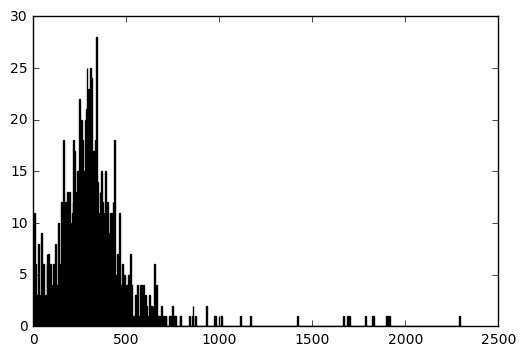

       descr_length   type_count          TTR
count   1062.000000  1062.000000  1062.000000
mean     324.409605   180.350282     0.583701
std      152.559189    65.243354     0.073305
min       52.000000    36.000000     0.369176
25%      225.500000   139.000000     0.539632
50%      306.000000   177.000000     0.579790
75%      396.000000   215.000000     0.630233
max     1167.000000   517.000000     0.833333


In [3]:
# histogram of descr_length

plt.hist(recruit_data['descr_length'], bins=range(min(recruit_data['descr_length']), max(recruit_data['descr_length']) + 5, 5))
plt.show()

# remove short descriptions

recruit_data = recruit_data[recruit_data.descr_length >= 50]

# remove long descriptions

recruit_data = recruit_data[recruit_data.descr_length <= \
                            ((recruit_data['descr_length'].mean()) +\
                           (4 * (recruit_data['descr_length'].std())))]

print(recruit_data.describe())


In [4]:
# build masculine dictionary

# begin list with whole words

masculine_words = ['active', 'adventurous', 'confident', 'decide', 'decisive',\
                  'dominant', 'greedy', 'headstrong', 'impulsive', 'logic', 'masculine',\
                  'objective', 'opinion', 'outspoken', 'persist', 'reckless',\
                  'stubborn', 'superior']

# identify possible stems from article

masculine_stems = ['aggress', 'ambitio', 'analy', 'assert', 'athlet', 'autonom',\
                  'boast', 'challeng', 'compet', 'courag', 'decision', 'determin',\
                  'domina', 'force', 'hierarch', 'hostil', 'independen', 'individual',\
                  'intellect', 'lead', 'principle', 'self-confiden', 'self-sufficien',\
                  'self-relian']

# identify exclusions

excluded_terms = ['committee']

# determine what words matching the word stems are present in the corpus

descriptions = recruit_data['descr_unique'].tolist()
desc_chain = chain.from_iterable(descriptions)
word_set = list(desc_chain)

masc_stems_found = list(set([word for word in word_set for stem in masculine_stems if (word.startswith(stem)\
                   and word not in excluded_terms)]))

masculine_dict = masculine_words + masc_stems_found

# print(masculine_dict)


In [5]:
# build feminine dictionary

# begin list with whole words

feminine_words = ['affectionate', 'communal', 'considerate', 'feminine', 'flatterable',\
                 'gentle', 'honest', 'kind', 'kinship', 'modesty', 'nag', 'polite',\
                 'submissive']

# identify possible stems from article

feminine_stems = ['child', 'cheer', 'commit', 'compassion', 'connect', 'cooperat',\
                 'depend', 'emotiona', 'empath', 'interdependen', 'interpersona',\
                 'loyal', 'nurtur', 'pleasant', 'quiet', 'respon', 'sensitiv',\
                 'support', 'sympath', 'tender', 'together', 'trust', 'understand',\
                 'warm', 'whin', 'yield']

# exclusions identified above

# determine what words matching the word stems are present in the corpus
## word_set defined above

femi_stems_found = list(set([word for word in word_set for stem in feminine_stems if (word.startswith(stem)\
                   and word not in excluded_terms)]))

feminine_dict = feminine_words + femi_stems_found

#print(feminine_dict)


In [6]:
# analyze masculine terms for dataset
# grab masculine words

recruit_data['masc_words'] = recruit_data['descr_analysis'].apply(lambda x: [word for word in x if word in masculine_dict])

# compute number and proportion of masculine words

recruit_data['masc_words_num'] = recruit_data['masc_words'].apply(len)
recruit_data['masc_words_pro'] = recruit_data['masc_words_num'] / recruit_data['descr_length']

# print mean # of masculine words in job description + var in sample

print('Avg. masculine words per job description:', recruit_data['masc_words_num'].mean())
print('Std. Dev.:', recruit_data['masc_words_num'].std())
print()
print('Avg. proportion masculine words:', recruit_data['masc_words_pro'].mean())
print('Std. Dev.:', recruit_data['masc_words_pro'].std())
print()

# most common 10 masculine words in job descriptions

masc_common = recruit_data['masc_words'].tolist()
cat_masc_common = list(chain.from_iterable(masc_common))
#print(cat_masc_common)
print('10 most frequent masculine words:', nltk.FreqDist(cat_masc_common).most_common()[:10])


Avg. masculine words per job description: 1.6685499058380415
Std. Dev.: 1.833125287418517

Avg. proportion masculine words: 0.004887950271483568
Std. Dev.: 0.004814738805108357

10 most frequent masculine words: [('leadership', 378), ('individuals', 253), ('analysis', 155), ('independent', 148), ('active', 116), ('competitive', 98), ('individual', 92), ('leading', 82), ('intellectual', 61), ('lead', 57)]


In [7]:
# analyze feminine terms for dataset

# grab feminine words

recruit_data['femi_words'] = recruit_data['descr_analysis'].apply(lambda x: [word for word in x if word in feminine_dict])

# compute number and proportion of feminine words

recruit_data['femi_words_num'] = recruit_data['femi_words'].apply(len)
recruit_data['femi_words_pro'] = recruit_data['femi_words_num'] / recruit_data['descr_length']

# print mean # of feminine words in job description + var in sample

print('Avg. feminine words per job description:', recruit_data['femi_words_num'].mean())
print('Std. Dev.:', recruit_data['femi_words_num'].std())
print()
print('Avg. proportion feminine words:', recruit_data['femi_words_pro'].mean())
print('Std. Dev.:', recruit_data['femi_words_pro'].std())
print()

# most common 10 feminine words in job descriptions

femi_common = recruit_data['femi_words'].tolist()
cat_femi_common = list(chain.from_iterable(femi_common))
#print(cat_femi_common)
print('10 most frequent feminine words:', nltk.FreqDist(cat_femi_common).most_common()[:10])


Avg. feminine words per job description: 2.1798493408662902
Std. Dev.: 2.232619281404016

Avg. proportion feminine words: 0.006373503804590149
Std. Dev.: 0.005384858788615758

10 most frequent feminine words: [('commitment', 588), ('committed', 490), ('support', 178), ('responsibilities', 168), ('understanding', 88), ('supports', 76), ('responsible', 67), ('children', 61), ('responsive', 54), ('children\x89ûªs', 43)]


                      masc_words_pro  femi_words_pro
UCOP_STEM_flag                                      
NON-STEM       count      299.000000      299.000000
               mean         0.003415        0.005849
               std          0.003783        0.004783
               min          0.000000        0.000000
               25%          0.000000        0.002994
               50%          0.002907        0.004684
               75%          0.005089        0.008811
               max          0.024096        0.031496
STEM           count      390.000000      390.000000
               mean         0.004912        0.005118
               std          0.004700        0.004606
               min          0.000000        0.000000
               25%          0.000000        0.000000
               50%          0.004115        0.004518
               75%          0.007188        0.007576
               max          0.025641        0.032967


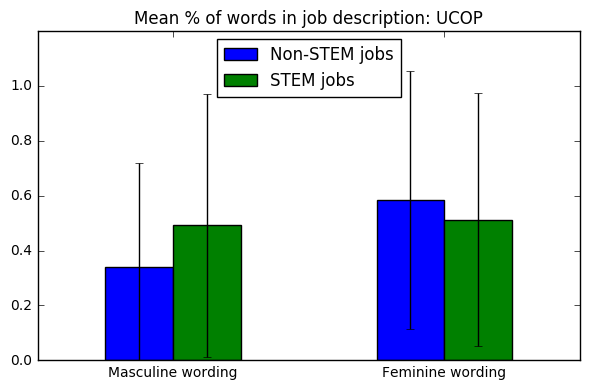

In [16]:
# for UCOP STEM flag

UCOP_group = recruit_data.groupby('UCOP_STEM_flag')
print(UCOP_group['masc_words_pro', 'femi_words_pro'].describe())

UCOP_mean = recruit_data.groupby('UCOP_STEM_flag').mean()

non_stem_masc_pro = UCOP_mean['masc_words_pro'][0]*100
stem_masc_pro = UCOP_mean['masc_words_pro'][1]*100

non_stem_femi_pro = UCOP_mean['femi_words_pro'][0]*100
stem_femi_pro = UCOP_mean['femi_words_pro'][1]*100

UCOP_err = recruit_data.groupby('UCOP_STEM_flag').std()

non_stem_masc_pro_err = UCOP_err['masc_words_pro'][0]*100
stem_masc_pro_err = UCOP_err['masc_words_pro'][1]*100

non_stem_femi_pro_err = UCOP_err['femi_words_pro'][0]*100
stem_femi_pro_err = UCOP_err['femi_words_pro'][1]*100

col_names = ['Non-STEM jobs', 'STEM jobs']
row_names = ['Masculine wording', 'Feminine wording']

gend_words = [[non_stem_masc_pro, stem_masc_pro], [non_stem_femi_pro, stem_femi_pro]]
gend_error = [[non_stem_masc_pro_err, stem_masc_pro_err], [non_stem_femi_pro_err, stem_femi_pro_err]]

pd.DataFrame(gend_words, columns = col_names, index = row_names).plot(kind = 'bar', title = 'Mean % of words in job description: UCOP', yerr = gend_error, rot = 0)
plt.ylim(0,1.2)
plt.legend(loc='upper center')
plt.tight_layout()
plt.savefig('../data/UCOP_gendered_lang.png')
plt.show()


                     masc_words_pro  femi_words_pro
CIP_STEM_flag                                      
Non-STEM      count      619.000000      619.000000
              mean         0.004714        0.006767
              std          0.004742        0.005367
              min          0.000000        0.000000
              25%          0.000000        0.003273
              50%          0.003717        0.005848
              75%          0.006985        0.009615
              max          0.035398        0.031496
STEM          count      400.000000      400.000000
              mean         0.004906        0.005467
              std          0.004617        0.004941
              min          0.000000        0.000000
              25%          0.000000        0.002049
              50%          0.004211        0.004819
              75%          0.007194        0.008065
              max          0.025641        0.032967


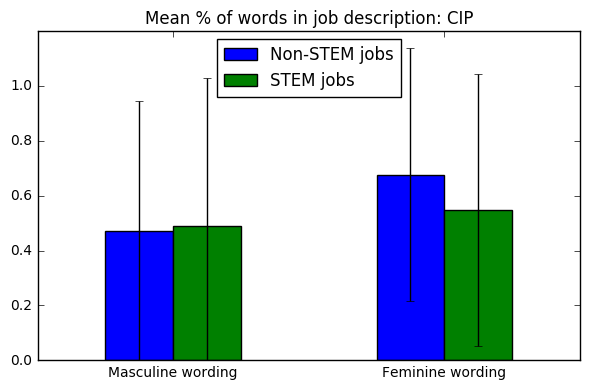

In [17]:
# for CIP STEM flag

CIP_group = recruit_data.groupby('CIP_STEM_flag')
print(CIP_group['masc_words_pro', 'femi_words_pro'].describe())

CIP_mean = recruit_data.groupby('CIP_STEM_flag').mean()

non_stem_masc_pro = CIP_mean['masc_words_pro'][0]*100
stem_masc_pro = CIP_mean['masc_words_pro'][1]*100

non_stem_femi_pro = CIP_mean['femi_words_pro'][0]*100
stem_femi_pro = CIP_mean['femi_words_pro'][1]*100

CIP_err = recruit_data.groupby('CIP_STEM_flag').std()

non_stem_masc_pro_err = CIP_err['masc_words_pro'][0]*100
stem_masc_pro_err = CIP_err['masc_words_pro'][1]*100

non_stem_femi_pro_err = CIP_err['femi_words_pro'][0]*100
stem_femi_pro_err = CIP_err['femi_words_pro'][1]*100

col_names = ['Non-STEM jobs', 'STEM jobs']
row_names = ['Masculine wording', 'Feminine wording']

gend_words = [[non_stem_masc_pro, stem_masc_pro], [non_stem_femi_pro, stem_femi_pro]]
gend_error = [[non_stem_masc_pro_err, stem_masc_pro_err], [non_stem_femi_pro_err, stem_femi_pro_err]]

pd.DataFrame(gend_words, columns = col_names, index = row_names).plot(kind = 'bar', title = 'Mean % of words in job description: CIP', yerr = gend_error, rot = 0)
plt.ylim(0,1.2)
plt.legend(loc='upper center')
plt.tight_layout()
plt.savefig('../data/CIP_gendered_lang.png')
plt.show()


                            masc_words_pro  femi_words_pro
STEM_SocSci_CIP_flag                                      
Non-STEM             count      541.000000      541.000000
                     mean         0.004796        0.007061
                     std          0.004775        0.005352
                     min          0.000000        0.000000
                     25%          0.000000        0.003448
                     50%          0.003745        0.006250
                     75%          0.007059        0.009901
                     max          0.035398        0.031496
STEM                 count      478.000000      478.000000
                     mean         0.004782        0.005346
                     std          0.004602        0.004961
                     min          0.000000        0.000000
                     25%          0.000000        0.000000
                     50%          0.004032        0.004608
                     75%          0.007168        0.0079

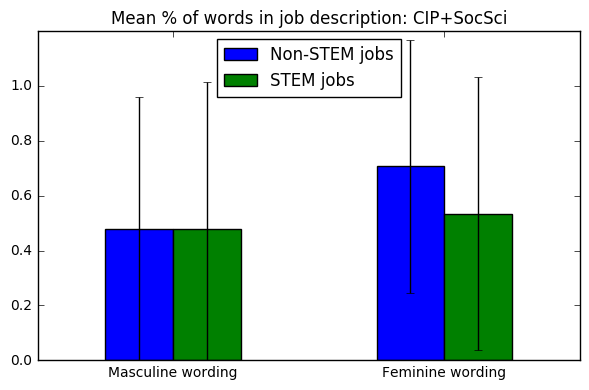

In [18]:
# for CIP + Soc Sci STEM flag

SSCIP_group = recruit_data.groupby('STEM_SocSci_CIP_flag')
print(SSCIP_group['masc_words_pro', 'femi_words_pro'].describe())

SSCIP_mean = recruit_data.groupby('STEM_SocSci_CIP_flag').mean()

non_stem_masc_pro = SSCIP_mean['masc_words_pro'][0]*100
stem_masc_pro = SSCIP_mean['masc_words_pro'][1]*100

non_stem_femi_pro = SSCIP_mean['femi_words_pro'][0]*100
stem_femi_pro = SSCIP_mean['femi_words_pro'][1]*100

SSCIP_err = recruit_data.groupby('STEM_SocSci_CIP_flag').std()

non_stem_masc_pro_err = SSCIP_err['masc_words_pro'][0]*100
stem_masc_pro_err = SSCIP_err['masc_words_pro'][1]*100

non_stem_femi_pro_err = SSCIP_err['femi_words_pro'][0]*100
stem_femi_pro_err = SSCIP_err['femi_words_pro'][1]*100

col_names = ['Non-STEM jobs', 'STEM jobs']
row_names = ['Masculine wording', 'Feminine wording']

gend_words = [[non_stem_masc_pro, stem_masc_pro], [non_stem_femi_pro, stem_femi_pro]]
gend_error = [[non_stem_masc_pro_err, stem_masc_pro_err], [non_stem_femi_pro_err, stem_femi_pro_err]]

pd.DataFrame(gend_words, columns = col_names, index = row_names).plot(kind = 'bar', title = 'Mean % of words in job description: CIP+SocSci', yerr = gend_error, rot = 0)
plt.ylim(0,1.2)
plt.legend(loc='upper center')
plt.savefig('../data/SSCIP_gendered_lang.png')
plt.tight_layout()
plt.show()


In [15]:
# generate new .csv file
recruit_data.to_csv('../data/recruit_prelim_v3.csv')


In [33]:
# find ten most common masculine and feminine terms in Non-STEM and STEM: UCOP

# build stem and non-stem strings

# note that UCOP STEM flag is different - uses all caps for "NON-"

non_stem_df = recruit_data[recruit_data.UCOP_STEM_flag == 'NON-STEM']
non_stem_descr = non_stem_df['description'].tolist()
non_stem_cat = ''.join(non_stem_descr)
non_stem_tokens = nltk.word_tokenize(non_stem_cat)
non_stem_tokens = [word.lower() for word in non_stem_tokens if word not in list(string.punctuation)]
non_stem_text = nltk.Text(non_stem_tokens)

stem_df = recruit_data[recruit_data.UCOP_STEM_flag == 'STEM']
stem_descr = stem_df['description'].tolist()
stem_cat = ''.join(stem_descr)
stem_tokens = nltk.word_tokenize(stem_cat)
stem_tokens = [word.lower() for word in stem_tokens if word not in list(string.punctuation)]
stem_text = nltk.Text(stem_tokens)

# UCOP most common terms

non_stem_masc_words = [word for word in non_stem_tokens if word in masculine_dict]
non_stem_masc_freq = nltk.FreqDist(non_stem_masc_words)
print("10 most common masculine terms (UCOP non-STEM):")
print(non_stem_masc_freq.most_common(n = 10))
print()

stem_masc_words = [word for word in stem_tokens if word in masculine_dict]
stem_masc_freq = nltk.FreqDist(stem_masc_words)
print("10 most common masculine terms (UCOP STEM):")
print(stem_masc_freq.most_common(n = 10))
print()

non_stem_femi_words = [word for word in non_stem_tokens if word in feminine_dict]
non_stem_femi_freq = nltk.FreqDist(non_stem_femi_words)
print("10 most common feminine terms (UCOP non-STEM):")
print(non_stem_femi_freq.most_common(n = 10))
print()

stem_femi_words = [word for word in stem_tokens if word in feminine_dict]
stem_femi_freq = nltk.FreqDist(stem_femi_words)
print("10 most common feminine terms (UCOP STEM):")
print(stem_femi_freq.most_common(n = 10))
print()

# context for most common terms in each category

# non-STEM masculine

print('Top masculine word context (UCOP non-STEM):')
non_stem_text.concordance('individuals', width = 100, lines = 300)
print()
print()

# STEM masculine

print('Top masculine word context (UCOP STEM):')
stem_text.concordance('individuals', width = 100, lines = 300)
print()
print()

# non-STEM feminine

print('Top feminine word context (UCOP non-STEM):')
non_stem_text.concordance('commitment', width = 100, lines = 300)
print()
print()

# STEM feminine

print('Top feminine word context (UCOP STEM):')
stem_text.concordance('commitment', width = 100, lines = 300)
print()
print()


10 most common masculine terms (UCOP non-STEM):
[('individuals', 64), ('leadership', 57), ('active', 38), ('leading', 31), ('analysis', 30), ('intellectual', 30), ('competitive', 15), ('competence', 14), ('individual', 11), ('superior', 6)]

10 most common masculine terms (UCOP STEM):
[('individuals', 101), ('leadership', 88), ('analysis', 75), ('competitive', 51), ('independent', 45), ('active', 31), ('leading', 21), ('lead', 19), ('individual', 18), ('analytical', 17)]

10 most common feminine terms (UCOP non-STEM):
[('commitment', 173), ('committed', 162), ('responsibilities', 36), ('supports', 32), ('understanding', 24), ('support', 20), ('connections', 18), ('committees', 10), ('children', 9), ('responsive', 9)]

10 most common feminine terms (UCOP STEM):
[('commitment', 145), ('committed', 126), ('responsibilities', 53), ('support', 39), ('understanding', 30), ('responsive', 24), ('supports', 24), ('supporting', 17), ('cooperative', 17), ('understand', 13)]

Top masculine word co

In [34]:
# find ten most common masculine and feminine terms in Non-STEM and STEM: CIP

# build stem and non-stem strings

non_stem_df = recruit_data[recruit_data.CIP_STEM_flag == 'Non-STEM']
non_stem_descr = non_stem_df['description'].tolist()
non_stem_cat = ''.join(non_stem_descr)
non_stem_tokens = nltk.word_tokenize(non_stem_cat)
non_stem_tokens = [word.lower() for word in non_stem_tokens if word not in list(string.punctuation)]
non_stem_text = nltk.Text(non_stem_tokens)

stem_df = recruit_data[recruit_data.CIP_STEM_flag == 'STEM']
stem_descr = stem_df['description'].tolist()
stem_cat = ''.join(stem_descr)
stem_tokens = nltk.word_tokenize(stem_cat)
stem_tokens = [word.lower() for word in stem_tokens if word not in list(string.punctuation)]
stem_text = nltk.Text(stem_tokens)

# CIP most common terms

non_stem_masc_words = [word for word in non_stem_tokens if word in masculine_dict]
non_stem_masc_freq = nltk.FreqDist(non_stem_masc_words)
print("10 most common masculine terms (CIP non-STEM):")
print(non_stem_masc_freq.most_common(n = 10))
print()

stem_masc_words = [word for word in stem_tokens if word in masculine_dict]
stem_masc_freq = nltk.FreqDist(stem_masc_words)
print("10 most common masculine terms (CIP STEM):")
print(stem_masc_freq.most_common(n = 10))
print()

non_stem_femi_words = [word for word in non_stem_tokens if word in feminine_dict]
non_stem_femi_freq = nltk.FreqDist(non_stem_femi_words)
print("10 most common feminine terms (CIP non-STEM):")
print(non_stem_femi_freq.most_common(n = 10))
print()

stem_femi_words = [word for word in stem_tokens if word in feminine_dict]
stem_femi_freq = nltk.FreqDist(stem_femi_words)
print("10 most common feminine terms (CIP STEM):")
print(stem_femi_freq.most_common(n = 10))
print()

# context for most common terms in each category

# non-STEM masculine

print('Top masculine word context (CIP non-STEM):')
non_stem_text.concordance('leadership', width = 100, lines = 300)
print()
print()

# STEM masculine

print('Top masculine word context (CIP STEM):')
stem_text.concordance('leadership', width = 100, lines = 300)
print()
print()

# non-STEM feminine

print('Top feminine word context (CIP non-STEM):')
non_stem_text.concordance('commitment', width = 100, lines = 400)
print()
print()

# STEM feminine

print('Top feminine word context (CIP STEM):')
stem_text.concordance('commitment', width = 100, lines = 400)
print()
print()


10 most common masculine terms (CIP non-STEM):
[('leadership', 230), ('individuals', 131), ('independent', 84), ('active', 70), ('analysis', 68), ('leading', 58), ('individual', 55), ('competitive', 50), ('intellectual', 38), ('leader', 31)]

10 most common masculine terms (CIP STEM):
[('leadership', 114), ('individuals', 107), ('analysis', 84), ('independent', 52), ('competitive', 44), ('active', 35), ('lead', 24), ('leading', 21), ('individual', 20), ('analytical', 20)]

10 most common feminine terms (CIP non-STEM):
[('commitment', 389), ('committed', 317), ('responsibilities', 109), ('support', 106), ('supports', 49), ('responsible', 44), ('understanding', 43), ('children', 36), ('children\x89ûªs', 35), ('committees', 29)]

10 most common feminine terms (CIP STEM):
[('commitment', 180), ('committed', 166), ('responsibilities', 50), ('support', 43), ('understanding', 37), ('supports', 27), ('responsive', 26), ('cooperative', 19), ('responsible', 15), ('responsibility', 14)]

Top masc

In [35]:
# find ten most common masculine and feminine terms in Non-STEM and STEM: CIP

# build stem and non-stem strings

non_stem_df = recruit_data[recruit_data.STEM_SocSci_CIP_flag == 'Non-STEM']
non_stem_descr = non_stem_df['description'].tolist()
non_stem_cat = ''.join(non_stem_descr)
non_stem_tokens = nltk.word_tokenize(non_stem_cat)
non_stem_tokens = [word.lower() for word in non_stem_tokens if word not in list(string.punctuation)]
non_stem_text = nltk.Text(non_stem_tokens)

stem_df = recruit_data[recruit_data.STEM_SocSci_CIP_flag == 'STEM']
stem_descr = stem_df['description'].tolist()
stem_cat = ''.join(stem_descr)
stem_tokens = nltk.word_tokenize(stem_cat)
stem_tokens = [word.lower() for word in stem_tokens if word not in list(string.punctuation)]
stem_text = nltk.Text(stem_tokens)

# CIP most common terms

non_stem_masc_words = [word for word in non_stem_tokens if word in masculine_dict]
non_stem_masc_freq = nltk.FreqDist(non_stem_masc_words)
print("10 most common masculine terms (CIP+SocSci non-STEM):")
print(non_stem_masc_freq.most_common(n = 10))
print()

stem_masc_words = [word for word in stem_tokens if word in masculine_dict]
stem_masc_freq = nltk.FreqDist(stem_masc_words)
print("10 most common masculine terms (CIP+SocSci STEM):")
print(stem_masc_freq.most_common(n = 10))
print()

non_stem_femi_words = [word for word in non_stem_tokens if word in feminine_dict]
non_stem_femi_freq = nltk.FreqDist(non_stem_femi_words)
print("10 most common feminine terms (CIP+SocSci non-STEM):")
print(non_stem_femi_freq.most_common(n = 10))
print()

stem_femi_words = [word for word in stem_tokens if word in feminine_dict]
stem_femi_freq = nltk.FreqDist(stem_femi_words)
print("10 most common feminine terms (CIP+SocSci STEM):")
print(stem_femi_freq.most_common(n = 10))
print()

# context for most common terms in each category

# non-STEM masculine

print('Top masculine word context (CIP+SocSci non-STEM):')
non_stem_text.concordance('leadership', width = 100, lines = 300)
print()
print()

# STEM masculine

print('Top masculine word context (CIP+SocSci STEM):')
stem_text.concordance('leadership', width = 100, lines = 300)
print()
print()

# non-STEM feminine

print('Top feminine word context (CIP+SocSci non-STEM):')
non_stem_text.concordance('commitment', width = 100, lines = 400)
print()
print()

# STEM feminine

print('Top feminine word context (CIP+SocSci STEM):')
stem_text.concordance('commitment', width = 100, lines = 400)
print()
print()


10 most common masculine terms (CIP+SocSci non-STEM):
[('leadership', 222), ('individuals', 118), ('independent', 84), ('analysis', 63), ('active', 61), ('leading', 56), ('individual', 55), ('intellectual', 38), ('leader', 31), ('competitive', 29)]

10 most common masculine terms (CIP+SocSci STEM):
[('leadership', 122), ('individuals', 120), ('analysis', 89), ('competitive', 65), ('independent', 52), ('active', 44), ('lead', 24), ('leading', 23), ('individual', 20), ('analytical', 20)]

10 most common feminine terms (CIP+SocSci non-STEM):
[('commitment', 359), ('committed', 284), ('support', 104), ('responsibilities', 103), ('supports', 46), ('responsible', 44), ('understanding', 43), ('children', 36), ('children\x89ûªs', 35), ('committees', 29)]

10 most common feminine terms (CIP+SocSci STEM):
[('commitment', 210), ('committed', 199), ('responsibilities', 56), ('support', 45), ('understanding', 37), ('supports', 30), ('responsive', 29), ('cooperative', 19), ('supporting', 15), ('resp